In [1]:
import numpy as np
import pandas as pd
import sys,os
import glob
import scipy.optimize as spo
sys.path.append(sys.path[0] + '/..')

import matplotlib.pyplot as plt
import matplotlib

from imp import reload
import platereaderclass as prc; reload(prc);
import plates_EstimateMSP as eMSP; reload(eMSP);


In [5]:
# for internal dynamics
volume_ecoli = 1e-15 # L
volume_well  = 2e-4  # L

eta_ecoli = volume_ecoli/volume_well

# growth parameters
growth_alpha = 1.049
growth_gamma = 1.320
growth_kappa = 7.049

# phi from fit
phi_andy     = 3.783e6
phi_philip   = 9.396e5


# get realistic parameters
def GetRhoEpsilon(tau = 1e6, logratio = 0, eta = 1, return_dict = False):
    ratio = 10**logratio
    eps = np.sqrt(2. / ratio / eta) * growth_alpha * growth_kappa * growth_gamma / (1. + growth_gamma) / tau
    rho = ratio * eps
    if return_dict: return {'rho': rho, 'epsilon': eps}
    else:           return rho, eps


def GetSigmaEB(phi = 1e6, logratio = 0, eta = 1, return_dict = False):
    ratio = 10**logratio
    sigmaE = np.sqrt(2. / ratio / eta) * growth_alpha * growth_kappa * growth_gamma / (1. + growth_gamma) / phi
    sigmaB = ratio * sigmaE
    if return_dict: return {'sigmaE': sigmaE, 'sigmaB': sigmaB}
    else:           return sigmaE, sigmaB

    
# plot all trajectories in dataframe
def PlotTrajectories(traj, ax = None, logscale = True, ylim = None):
    if ax is None:
        fig,ax = plt.subplots(1,1,figsize = (15,8))
    for c in traj.columns:
        ax.plot(traj.index, traj[c], label = c)
    if logscale:
        ax.set_yscale('log')
    if not ylim is None:
        ax.set_ylim(ylim)

In [7]:
class TimeIntegrator(object):
    def __init__(self, **kwargs):
        self.AlgParams         = {'IntegrationStep': kwargs.get('IntegrationStep', 2e-3),
                                  'OutputStep':      kwargs.get('OutputStep', 50),
                                  'Runtime':         kwargs.get('Runtime', 24)}

        self.__StoreRuns       = kwargs.get('StoreRuns', False)
        
        self.Params            = {}
        self.Restrictions      = []

        self.InitialConditions = {}
        self.TrajectoryNames   = []

        self.Trajectories      = []
        
        self.Reset()
        

    def RungeKutta4(self, x):
        # 4th order Runge-Kutta integration scheme
        k1 = self.AlgParams['IntegrationStep'] * self.Dynamics(x,            self.time)
        k2 = self.AlgParams['IntegrationStep'] * self.Dynamics(x + 0.5 * k1, self.time + 0.5 * self.AlgParams['IntegrationStep'])
        k3 = self.AlgParams['IntegrationStep'] * self.Dynamics(x + 0.5 * k2, self.time + 0.5 * self.AlgParams['IntegrationStep'])
        k4 = self.AlgParams['IntegrationStep'] * self.Dynamics(x + k3,       self.time +       self.AlgParams['IntegrationStep'])
        return x + (k1 + 2. * k2 + 2. * k3 + k4)/6.
    

    def Dynamics(self, x, time):
        # needs to be redefined upon inheritance
        return 0
    
    
    def Reset(self, **kwargs):
        # possible parameter or IC update
        for key,value in kwargs.items():
            if key in self.InitialConditions.keys(): self.InitialConditions.update({key:value})
            elif key in self.Params.keys():          self.Params.update({key:value})
        
        # set everything to starting values
        self.time = 0
        self.x    = np.array([[self.InitialConditions[name] for name in self.TrajectoryNames]])
    
    
    def Run(self, runtime = None):
        if runtime is None:
            runtime = self.AlgParams['Runtime']
        
        i         = 0
        xlast     = self.x[-1]
        starttime = self.time
        while self.time <= runtime + starttime:
            xnew  = self.RungeKutta4(xlast)
            
            # check for restrictions: concentrations can't go below zero or weird things happen
            for name, value1, value2 in self.Restrictions:
                if xnew[self.TrajectoryNames.index(name)] < value1:
                    xnew[self.TrajectoryNames.index(name)] = value2
            
            xlast = xnew
            i    += 1
            
            if i % self.AlgParams['OutputStep'] == 0:
                self.x = np.concatenate([self.x, [xnew]], axis = 0)
            
            self.time += self.AlgParams['IntegrationStep']
        
        # prepare pandas dataframe as output
        retdict = {'Time': np.arange(len(self.x[:,0])) * self.AlgParams['IntegrationStep'] * self.AlgParams['OutputStep']}
        retdict.update({name:self.x[:,i] for i,name in enumerate(self.TrajectoryNames)})
        retpd = pd.DataFrame(retdict).set_index('Time')
        
        if self.__StoreRuns:
            self.Trajectories.append((self.Params, self.InitialConditions, retpd))
        
        return retpd

    
    
class EnzymePopulationDynamics(TimeIntegrator):
    def __init__(self, **kwargs):
        super(EnzymePopulationDynamics, self).__init__(**kwargs)
        
        self.TrajectoryNames   = ['N', 'E', 'B']
        
        self.InitialConditions = {'N': kwargs.get('N', 1e4),
                                  'E': kwargs.get('E', 0),
                                  'B': kwargs.get('B', 1.5)}
        
        self.Restrictions      = [('N',1,0), ('E',0,0), ('B',0,0)]
        
        self.Params            = {'epsilon':    kwargs.get('epsilon',1e-3),
                                  'rho':        kwargs.get('rho',1e-3),
                                  'growthrate': kwargs.get('growthrate',1.),
                                  'kappa':      kwargs.get('kappa',2.),
                                  'gamma':      kwargs.get('gamma',2.)}
        
        self.Reset()
    
    
    def Dynamics(self, x, time):
        bk = np.power(x[2], self.Params['kappa'])
        return np.array([
            self.Params['growthrate'] * (1 - bk)/(1 + bk/self.Params['gamma']) * x[0],
            self.Params['rho'] * x[0],
            np.max([-self.Params['epsilon'] * x[1] * x[2],-x[2]]) # second max option restricts
                                                                  # large changes in integrator step.
                                                                  # enzyme x[1] can explode on exp grow pop x[0]
        ])
    

    
class EnzymePopulationDynamicsInternal(TimeIntegrator):
    def __init__(self, **kwargs):
        super(EnzymePopulationDynamicsInternal, self).__init__(**kwargs)
        
        self.TrajectoryNames   = ['N', 'Ein', 'Eout', 'Bin', 'Bout' ]#, 'Bout_Din', 'Bout_Dout']
        
        self.Restrictions      = [('N',1,0), ('Ein',0,0), ('Eout',0,0), ('Bin',0,0), ('Bout',0,0)]
        
        self.Params            = {'epsilon':    kwargs.get('epsilon',1e-3),
                                  'rho':        kwargs.get('rho',1e-3),
                                  'growthrate': kwargs.get('growthrate',1.),
                                  'kappa':      kwargs.get('kappa',2.),
                                  'gamma':      kwargs.get('gamma',2.),
                                  'sigmaE':     kwargs.get('sigmaE', 1e-4),
                                  'sigmaB':     kwargs.get('sigmaB', 1e-2),
                                  'eta':        kwargs.get('eta', eta_ecoli)}

        Ein = self.Params['rho']/self.Params['sigmaE']
        Bin = 1/(1 + self.Params['rho'] * self.Params['epsilon'] / self.Params['sigmaE'] / self.Params['sigmaB']) * kwargs.get('Bout',1.5)
        
        self.InitialConditions = {'N':          kwargs.get('N', 1e4),
                                  'Ein':        kwargs.get('Ein', Ein),
                                  'Eout':       kwargs.get('Eout', 0),
                                  'Bin':        kwargs.get('Bin', Bin),
                                  'Bout':       kwargs.get('Bout', 1.5)
                                 }
        
        self.Reset()

        
    def Dynamics(self, x, time):
        bk = np.power(x[3], self.Params['kappa'])
        return np.array([
            self.Params['growthrate'] * (1 - bk)/(1 + bk/self.Params['gamma']) * x[0],
            self.Params['rho'] + self.Params['sigmaE'] * (x[2] - x[1]),
            self.Params['eta'] * x[0] * self.Params['sigmaE'] * (x[1] - x[2]),
            -self.Params['epsilon'] * x[1] * x[3] + self.Params['sigmaB'] * (x[4] - x[3]),
            -self.Params['epsilon'] * x[2] * x[4] + self.Params['sigmaB'] * self.Params['eta'] * x[0] * (x[3] - x[4])
        ])

    


In [4]:
params = {'growthrate': growth_alpha,
          'kappa':      growth_kappa,
          'gamma':      growth_gamma,
          'StoreRuns':  True}

params.update(GetRhoEpsilon(tau = 1e6, return_dict = True))
#params.update(GetSigmaEB(phi = phi_andy, return_dict = True))

params_internal = params.copy()
params_internal['rho'],    params_internal['epsilon'] = GetRhoEpsilon(tau = 1e6, eta=eta_ecoli)
params_internal['sigmaE'], params_internal['sigmaB']  = GetSigmaEB(phi = phi_andy, eta=eta_ecoli)


dynSimp = EnzymePopulationDynamics(**params)
dynInt = EnzymePopulationDynamicsInternal(**params_internal)

print(params)
print(params_internal)


phi = params_internal['rho']*params_internal['epsilon']/(params_internal['sigmaB']*params_internal['sigmaE'])
print(phi)

{'growthrate': 1.049, 'kappa': 7.049, 'gamma': 1.32, 'StoreRuns': True, 'rho': 5.949821585072945e-06, 'epsilon': 5.949821585072945e-06}
{'growthrate': 1.049, 'kappa': 7.049, 'gamma': 1.32, 'StoreRuns': True, 'rho': 2.660841103643731, 'epsilon': 2.660841103643731, 'sigmaE': 0.7033679893322048, 'sigmaB': 0.7033679893322048}
14.311089000000003


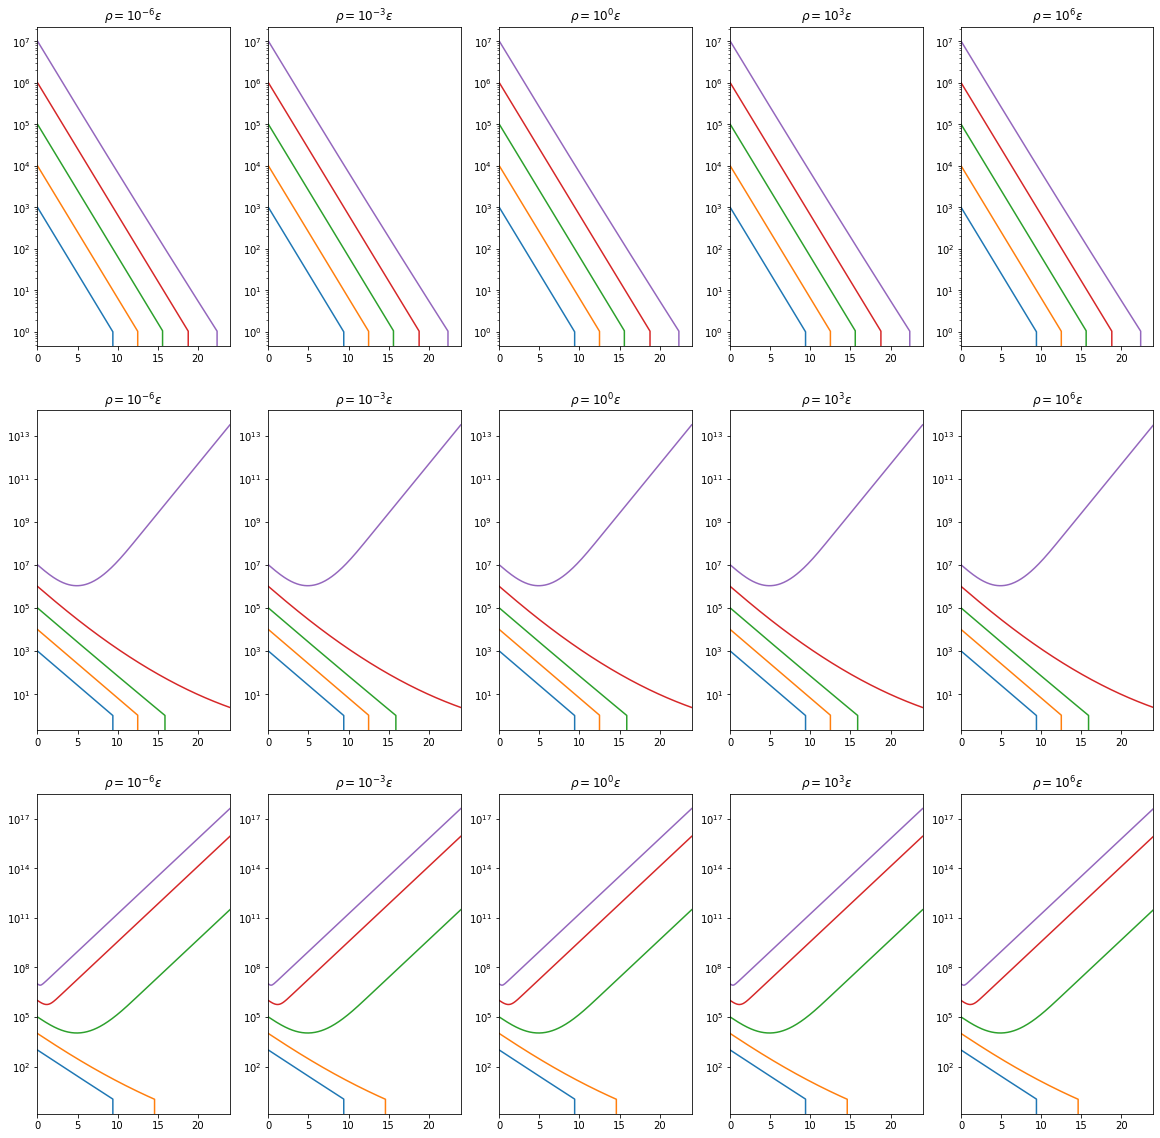

In [8]:
fig,ax = plt.subplots(3,5,figsize = (20,20))

for red in range(3):
    for lr in range(5):
        r,e = GetRhoEpsilon(logratio= 3 * (lr - 2), tau = 10**(6-red))
        for nexp in np.linspace(3,7,5):
            dynSimp.Reset(N = 10**nexp, B = 1.2, rho = r, epsilon = e)
            trajSimp = dynSimp.Run()

            ax[red,lr].plot(trajSimp.index, trajSimp['N'])

        ax[red,lr].set_title(r'$\rho = 10^{{{}}}\epsilon$'.format(3*(lr-2)))
        ax[red,lr].set_yscale('log')
        ax[red,lr].set_xlim(0,24)

    

In [9]:
dynInt.Reset()
traj = dynInt.Run()

<ipython-input-3-aafd921c3726>:146: RuntimeWarning: invalid value encountered in power
  bk = np.power(x[3], self.Params['kappa'])


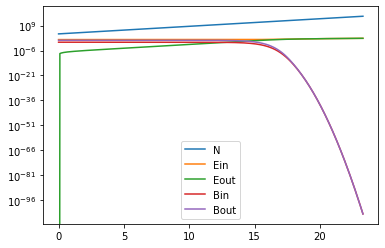

In [10]:
for c in traj.columns:
    plt.plot(traj.index, traj[c], label = c)
plt.yscale('log')
plt.legend()

In [18]:
dynEPDInt = EnzymePopulationDynamicsInternal(**params_internal, IntegrationStep = 1e-3, OutputStep = 100)
dynEPD    = EnzymePopulationDynamics(**params,          IntegrationStep = 1e-3, OutputStep = 100)


0.5


<ipython-input-7-8cc99dab8acc>:144: RuntimeWarning: invalid value encountered in power
  bk = np.power(x[3], self.Params['kappa'])


0.6
0.7
0.8
0.9
1.0
1.1
1.2000000000000002
1.3
1.4
1.5
1.6
1.7000000000000002
1.8
1.9000000000000001
2.0


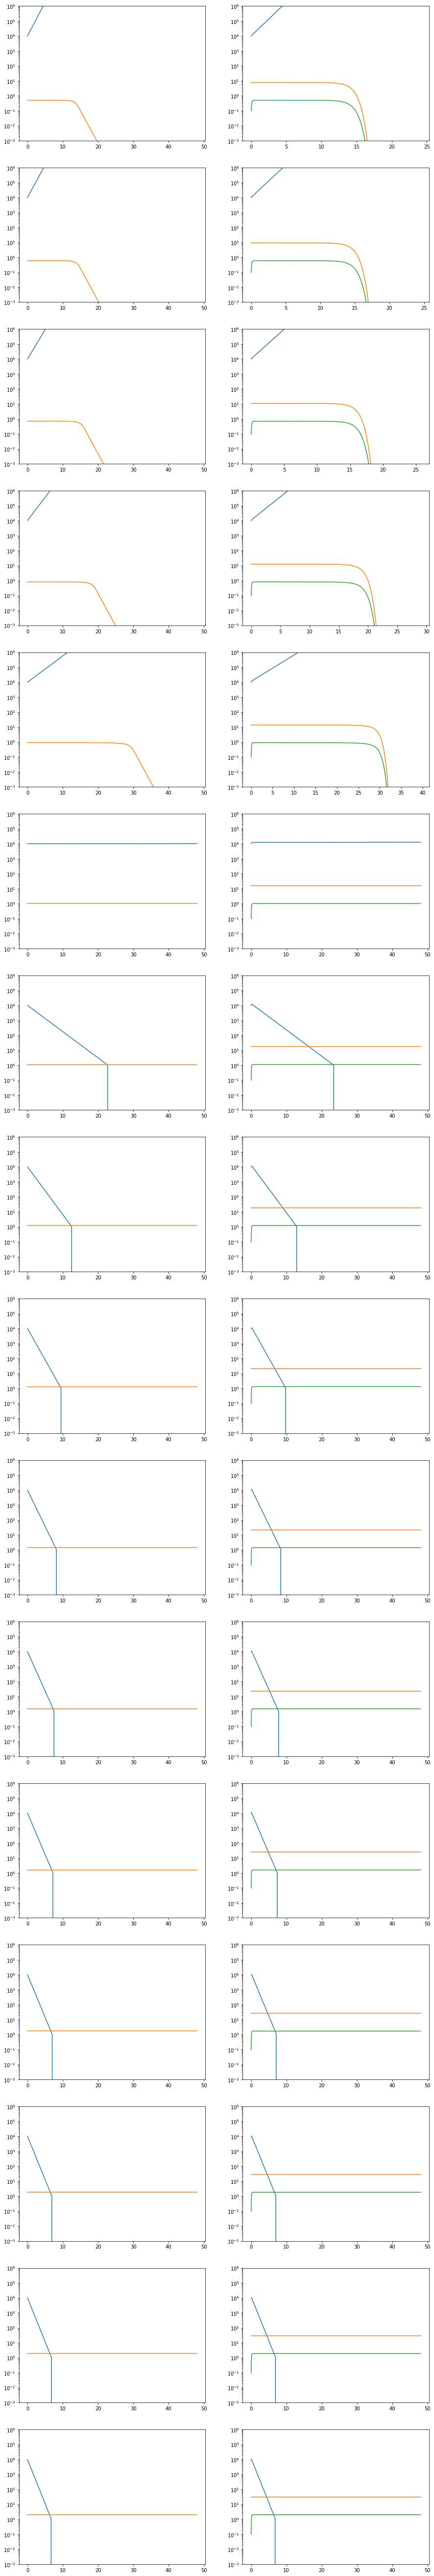

In [20]:
def PlotTrajectories(traj, ax = None, logscale = True, ylim = None):
    if ax is None:
        fig,ax = plt.subplots(1,1,figsize = (15,8))
    for c in traj.columns:
        ax.plot(traj.index, traj[c], label = c)
    if logscale:
        ax.set_yscale('log')
    if not ylim is None:
        ax.set_ylim(ylim)
        
bout_all = np.linspace(.5,2,16)
fig,ax = plt.subplots(len(bout_all),2, figsize = (15,6*len(bout_all)))

for i,bo in enumerate(bout_all):
    print(bo)
    boInt = bo * (1 + params_internal['rho'] * params_internal['epsilon'] / (params_internal['sigmaE'] * params_internal['sigmaB']))
    
    dynEPD.Reset(B = bo)
    t1 = dynEPD.Run(runtime = 48)
    dynEPDInt.Reset(Bout = boInt)
    t2 = dynEPDInt.Run(runtime = 48)
    
    PlotTrajectories(t1[['N','B']],ax[i,0], ylim = [1e-3,1e6])
    PlotTrajectories(t2[['N','Bout','Bin']],ax[i,1], ylim = [1e-3,1e6])
    

In [ ]:
dynIntNew = EnzymePopulationDynamicsInternal(**params_internal)

bout_all2 = np.linspace(5,20,4)
n_all = 10**np.linspace(2,5,4)

fig,ax = plt.subplots(4,4,figsize = (20,20))

for i,b0 in enumerate(bout_all2):
    for j,n0 in enumerate(n_all):
        dynIntNew.Reset(N = n0, Bout = b0)
        t = dynIntNew.Run(runtime = 48)
        PlotTrajectories(t[['N','Bout']], ax[i,j], ylim = [1e-2,1e10])
    

In [ ]:
fig,ax = plt.subplots(4,1, figsize = (15,8))

for i in range(4):
    ax[i].plot(dynIntSmallSteps.Trajectories[2*i][2].index, dynIntSmallSteps.Trajectories[2*i][2]['Bout'])
    ax[i].plot(dynIntSmallSteps.Trajectories[2*i][2].index, dynIntSmallSteps.Trajectories[2*i][2]['Bin'])
    #ax[i].set_yscale('log')
    ax[i].set_ylim([0,3])

In [ ]:
t

In [ ]:
fig,ax = plt.subplots(figsize = (20,10))
for c in t.columns:
    ax.plot(t.index, t[c], label = c)
ax.legend()
ax.set_yscale('log')
ax.set_ylim([1e-6,1e30])

In [ ]:
fig,ax = plt.subplots(1,2,figsize = (15,7))

ax[0].plot(t.index, t['Ein'], label = 'Ein')
ax[0].plot(t.index, t['Eout'], label = 'Eout')

ax[1].plot(t.index, t['Bin'], label = 'Bin')
ax[1].plot(t.index, t['Bout'], label = 'Bout')

ax[0].legend()
ax[1].legend()
ax[0].set_ylim(0,.0002)
ax[1].set_ylim(0,.002)




In [ ]:
minF, maxF = 0, 6

fig,ax = plt.subplots(maxF-minF,1, figsize = (15, 8*(maxF-minF)))

sE,sB = params['sigmaE'], params['sigmaB']
dynChangeSigma = EnzymePopulationDynamicsInternal(**params)


for i,sigma_factor_exp in enumerate(range(minF, maxF)):
    dynChangeSigma.Reset(sigmaE = sE*10**sigma_factor_exp, sigmaB = sB*10**sigma_factor_exp, N = 1e3)
    t = dynChangeSigma.Run(runtime=48)
    ax[i].plot(t.index, t['Ein'], label = r'$E_{in}$')
    ax[i].plot(t.index, t['Eout'], label = r'$E_{out}$')
    ax[i].plot(t.index, t['Bin'], label = r'$B_{in}$')
    ax[i].plot(t.index, t['Bout'], label = r'$B_{out}$')
    ax[i].plot(t.index, t['N'], label =r'$N$')
    ax[i].set_yscale('log')
    ax[i].set_ylim([1e-6,1e4])
    ax[i].set_xlim(0,48)
    ax[i].set_title(r'$\sigma_E = {:.2e}, \sigma_B = {:.2e}$'.format(sE*10**sigma_factor_exp, sB*10**sigma_factor_exp))
    ax[i].legend()

In [ ]:
dyn2 = EnzymePopulationDynamicsInternal2(**params)

In [ ]:
t = dyn2.Run()

In [ ]:
fig,ax = plt.subplots(1,2,figsize = (15,7))

ax[0].plot(t.index, t['Ein'], label = 'Ein')
ax[0].plot(t.index, t['Eout'], label = 'Eout')

ax[1].plot(t.index, t['Bin'], label = 'Bin')
ax[1].plot(t.index, t['Bout'], label = 'Bout')

ax[0].legend()
ax[1].legend()
ax[0].set_ylim(0,.002)
ax[1].set_ylim(0,2)
#ax[0].set_yscale('log')
#ax[1].set_yscale('log')


In [ ]:
dynEPD = EnzymePopulationDynamicsInternal2(**params)

fig,ax = plt.subplots(15,3, figsize = (15,60))

print(np.linspace(.5,4,15))

for i,bout in enumerate(np.linspace(.5,4,15)):
    #break
    dynEPD.Reset(Bout = bout)
    t = dynEPD.Run()
    
    ax[i,0].plot(t.index, t['Ein'], label = 'Ein')
    ax[i,0].plot(t.index, t['Eout'], label = 'Eout')

    ax[i,1].plot(t.index, t['Bin'], label = 'Bin')
    ax[i,1].plot(t.index, t['Bout'], label = 'Bout')
    
    ax[i,2].plot(t.index, t['N'])
    
    ax[i,0].set_title(r'$B_\mathrm{{out}} = {:.1f}$'.format(bout))
    ax[i,0].set_ylim(0,2e-3)
    ax[i,1].set_ylim(0,3)
    ax[i,2].set_yscale('log')